✅ Total images found: 5712
🧾 Class distribution:
 class
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64
Found 3883 validated image filenames belonging to 4 classes.
Found 686 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 154s 688ms/step - accuracy: 0.7542 - loss: 0.6306 - val_accuracy: 0.9038 - val_loss: 0.3328
Epoch 2/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 54s 438ms/step - accuracy: 0.9540 - loss: 0.1396 - val_accuracy: 0.8980 - val_loss: 0.3861
Epoch 3/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 54s 443ms/step - accuracy: 0.9634 - loss: 0.1093 - val_accuracy: 0.9490 - val_loss: 0.1691
Epoch 4/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 54s 441ms/step - accuracy: 0.9750 - loss: 0.0826 - val_accuracy: 0.9373 - val_loss: 0.2087
Epoch 5/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 54s 443ms/step - accuracy: 0.9779 - loss: 0.0621 - val_accuracy: 0.8761 - val_loss: 0.5780


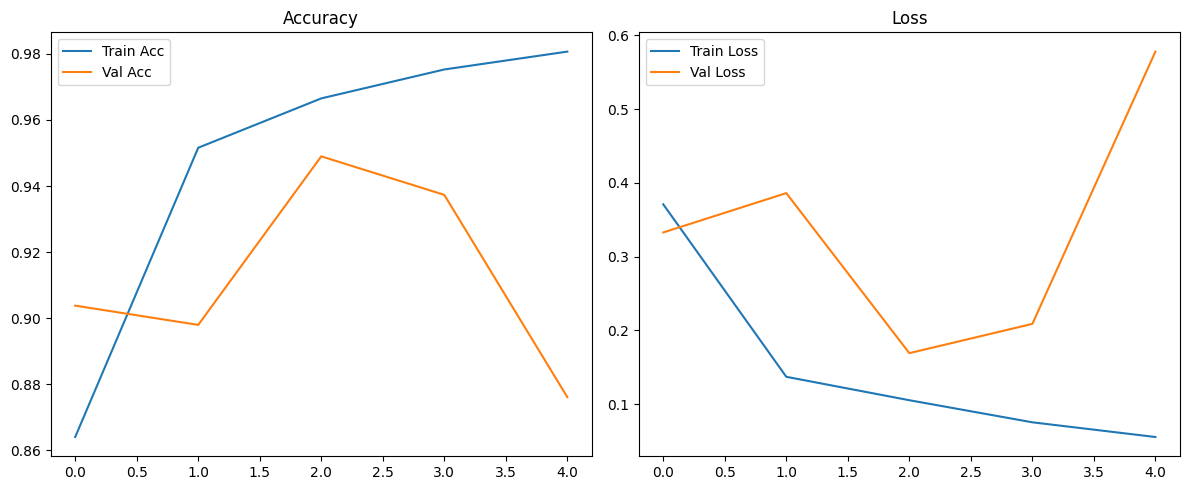

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.9627 - loss: 0.1308
✅ Test Accuracy: 0.9606
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step

Classification Report:
               precision    recall  f1-score   support

      glioma       0.93      0.98      0.95       264
  meningioma       0.93      0.94      0.94       268
     notumor       0.99      0.98      0.99       319
   pituitary       0.98      0.95      0.96       292

    accuracy                           0.96      1143
   macro avg       0.96      0.96      0.96      1143
weighted avg       0.96      0.96      0.96      1143



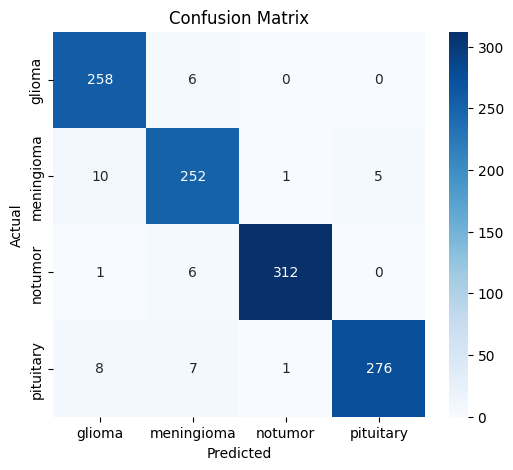

In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ⚙️ Parameters
DATASET_PATH = "/kaggle/input/brain-tumar-mri-datset-kaggle-7000-images/Training"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5  # Increase for better performance
NUM_CLASSES = 4

# 🧠 Step 1: Load image paths and labels
image_paths, labels = [], []
class_dirs = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
for class_dir in class_dirs:
    class_path = os.path.join(DATASET_PATH, class_dir)
    for fname in os.listdir(class_path):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_path, fname))
            labels.append(class_dir)

df = pd.DataFrame({'filename': image_paths, 'class': labels})
print(f"✅ Total images found: {len(df)}")
print("🧾 Class distribution:\n", df['class'].value_counts())

# 🧪 Step 2: Split dataset
train_df, test_df = train_test_split(df, stratify=df['class'], test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['class'], test_size=0.15, random_state=42)

# 🔄 Step 3: Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filename', y_col='class',
                                              target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                              class_mode='categorical')
val_gen = valid_datagen.flow_from_dataframe(val_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical', shuffle=False)

# 🔧 Step 4: Build model using ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
preds = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

# ⚙️ Step 5: Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 📦 Step 6: Callbacks
checkpoint = ModelCheckpoint('resnet50_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 🏋️ Step 7: Train model
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=EPOCHS,
                    callbacks=[checkpoint, earlystop])

# 📈 Step 8: Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 🧪 Step 9: Evaluate on test set
loss, acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {acc:.4f}")

# 🧾 Step 10: Classification report and confusion matrix
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
class_labels = list(test_gen.class_indices.keys())

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [7]:
from sklearn.metrics import accuracy_score

# ✅ Step 11: Overall Accuracy
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"\n🎯 Overall Test Accuracy (manual calc): {overall_accuracy * 100:.2f}%")



🎯 Overall Test Accuracy (manual calc): 96.06%
